In [197]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [198]:
%cd /content/drive/MyDrive/IPL_Dataset/

/content/drive/MyDrive/IPL_Dataset


In [199]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


**Reading Dataset**

In [200]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

batting_df = pd.read_csv("all_season_batting_card.csv",low_memory=False)
bowling_df = pd.read_csv("all_season_bowling_card.csv",low_memory=False)
season_df = pd.read_csv("all_season_details.csv",low_memory=False)
season_summary_df = pd.read_csv("all_season_summary.csv",low_memory=False)
points_df = pd.read_csv("points_table.csv",low_memory=False)

In [201]:
season_df.head()

,comment_id,season,match_id,match_name,home_team,away_team,current_innings,innings_id,over,ball,runs,shortText,isBoundary,isWide,isNoball,batsman1_id,batsman1_name,batsman1_runs,batsman1_balls,bowler1_id,bowler1_name,bowler1_overs,bowler1_maidens,bowler1_runs,bowler1_wkts,batsman2_id,batsman2_name,batsman2_runs,batsman2_balls,bowler2_id,bowler2_name,bowler2_overs,bowler2_maidens,bowler2_runs,bowler2_wkts,wicket_id,wkt_batsman_name,wkt_bowler_name,wkt_batsman_runs,wkt_batsman_balls,wkt_text,isRetiredHurt,text,preText,postText
0,120,2022,1304047,CSK v KKR,CSK,KKR,CSK,1,1,1,0,"Yadav to Gaikwad, no run",False,False,False,1060380,Ruturaj Gaikwad,0,2,376116,Umesh Yadav,0.1,0,1,0,379140,Devon Conway,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,beaten as he has a wild swing at this full del...,<p>There's a wide slip in place btw</p>,NaN
1,110,2022,1304047,CSK v KKR,CSK,KKR,CSK,1,1,1,1,"Yadav to Gaikwad, 1 no ball",False,False,True,1060380,Ruturaj Gaikwad,0,1,376116,Umesh Yadav,0.0,0,1,0,379140,Devon Conway,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,starts with a zippy back of length delivery th...,<p><b>7.28pm </b> Gaikwad and Conway are the o...,NaN
2,140,2022,1304047,CSK v KKR,CSK,KKR,CSK,1,1,2,0,"Yadav to Gaikwad, no run",False,False,False,1060380,Ruturaj Gaikwad,0,3,376116,Umesh Yadav,0.2,0,2,0,379140,Devon Conway,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,terrific delivery. Bolt upright seam to land i...,NaN,NaN
3,130,2022,1304047,CSK v KKR,CSK,KKR,CSK,1,1,2,1,"Yadav to Gaikwad, 1 wide",False,True,False,1060380,Ruturaj Gaikwad,0,2,376116,Umesh Yadav,0.1,0,2,0,379140,Devon Conway,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,"slips this back of a length delivery down leg,...",NaN,NaN
4,150,2022,1304047,CSK v KKR,CSK,KKR,CSK,1,1,3,0,"Yadav to Gaikwad, OUT",False,False,False,1060380,Ruturaj Gaikwad,0,4,376116,Umesh Yadav,0.3,0,2,1,379140,Devon Conway,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1060380.0,Ruturaj Gaikwad,Umesh Yadav,0.0,4.0,RD Gaikwad c Rana b Yadav 0 (5m 4b 0x4 0x6) SR...,False,<b> edged and taken at slip! </b> Uncharacteri...,NaN,NaN


In [202]:
season_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224938 entries, 0 to 224937
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   comment_id         224938 non-null  int64  
 1   season             224938 non-null  int64  
 2   match_id           224938 non-null  int64  
 3   match_name         224938 non-null  object 
 4   home_team          224938 non-null  object 
 5   away_team          224938 non-null  object 
 6   current_innings    224938 non-null  object 
 7   innings_id         224938 non-null  int64  
 8   over               224938 non-null  int64  
 9   ball               224938 non-null  int64  
 10  runs               224938 non-null  int64  
 11  shortText          224938 non-null  object 
 12  isBoundary         224938 non-null  bool   
 13  isWide             224938 non-null  bool   
 14  isNoball           224938 non-null  bool   
 15  batsman1_id        224938 non-null  int64  
 16  ba

## **Data Preprocessing**

In [203]:
season_df.insert(15,'isWicket',value=False)
season_df['isWicket'] = ~season_df['wicket_id'].isnull()
drop_cols = ['comment_id', 'match_name', 'wkt_batsman_name', 'wkt_bowler_name', 'wicket_id', 'bowler2_name','shortText','wkt_text', 'text', 'preText', 'postText']
season_df = season_df.drop(drop_cols, axis=1)
season_df['batsman_runs'] = season_df['runs'] - np.where(season_df['isWide'], 1, 0) - np.where(season_df['isNoball'], 1, 0)
season_df.fillna(0.0,inplace=True)

season_summary_df.replace("KXIP", "PBKS", inplace=True)
#season_summary_df = season_summary_df[['id','home_team', 'away_team', 'toss_won', 'decision', 'winner', 'season']]
season_summary_df['decision'] = season_summary_df['decision'].str.split().str[0]

## **Exploratory Data Analysis**

**Maximum Toss Winners**

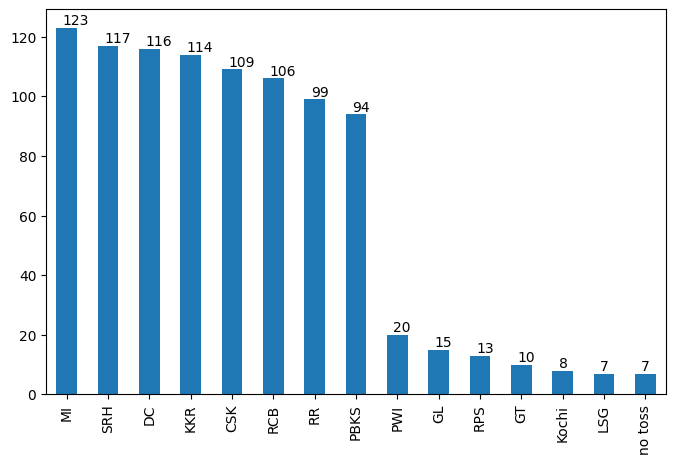

In [204]:
plt.subplots(figsize=(8,5))
ax=season_summary_df['toss_won'].value_counts().plot.bar(width=0.5)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.show()

**Toss Decision wrt Season**

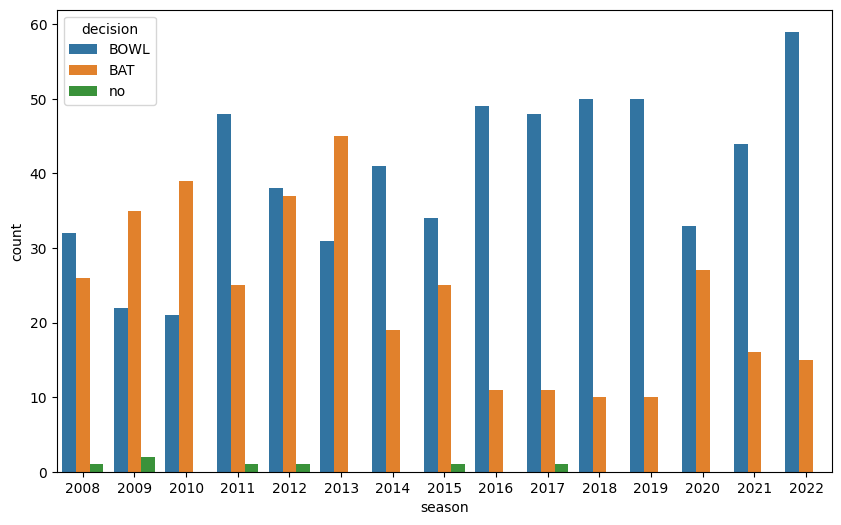

In [205]:
plt.subplots(figsize=(10,6))
sns.countplot(x='season',hue='decision',data=season_summary_df)
plt.show()

**Toss Decision wrt Team**

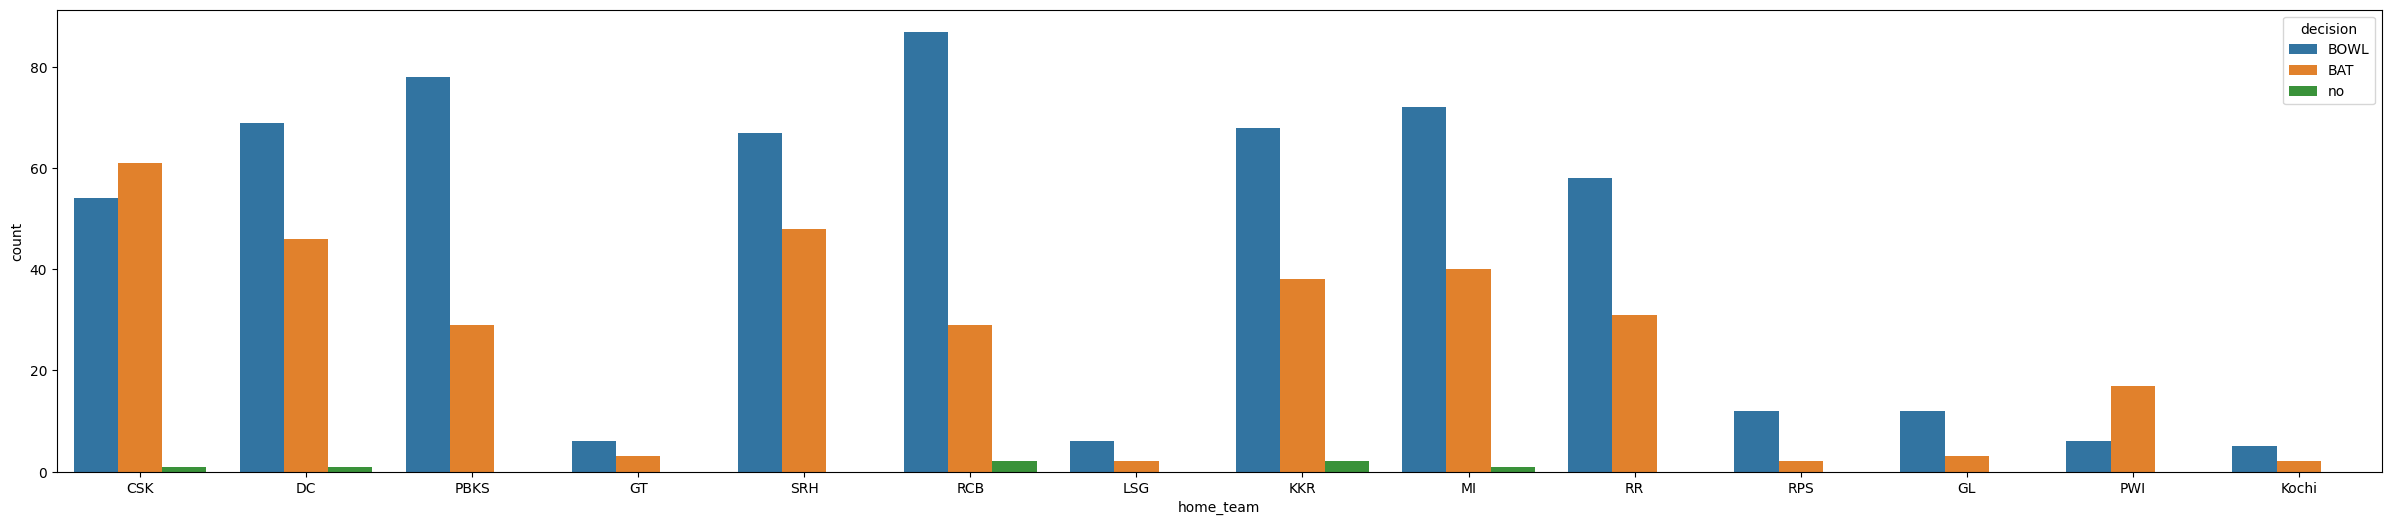

In [206]:
plt.subplots(figsize=(30,6))
sns.countplot(x='home_team',hue='decision',data=season_summary_df)
plt.show()

**Maximum Wins**

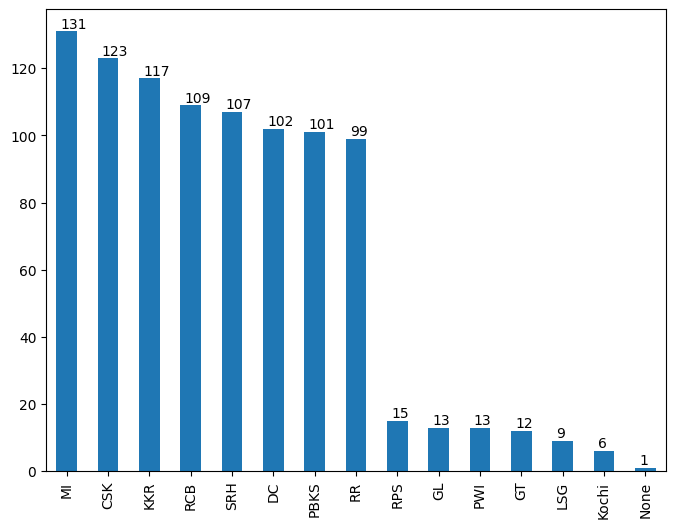

In [207]:
plt.subplots(figsize=(8,6))
wnrs = season_summary_df['winner'].value_counts().plot.bar(width=0.5)
for x in wnrs.patches:
  wnrs.annotate(format(x.get_height()),(x.get_x()+0.1,x.get_height()+1))
plt.show()

**Total Matches vs Wins for Teams**

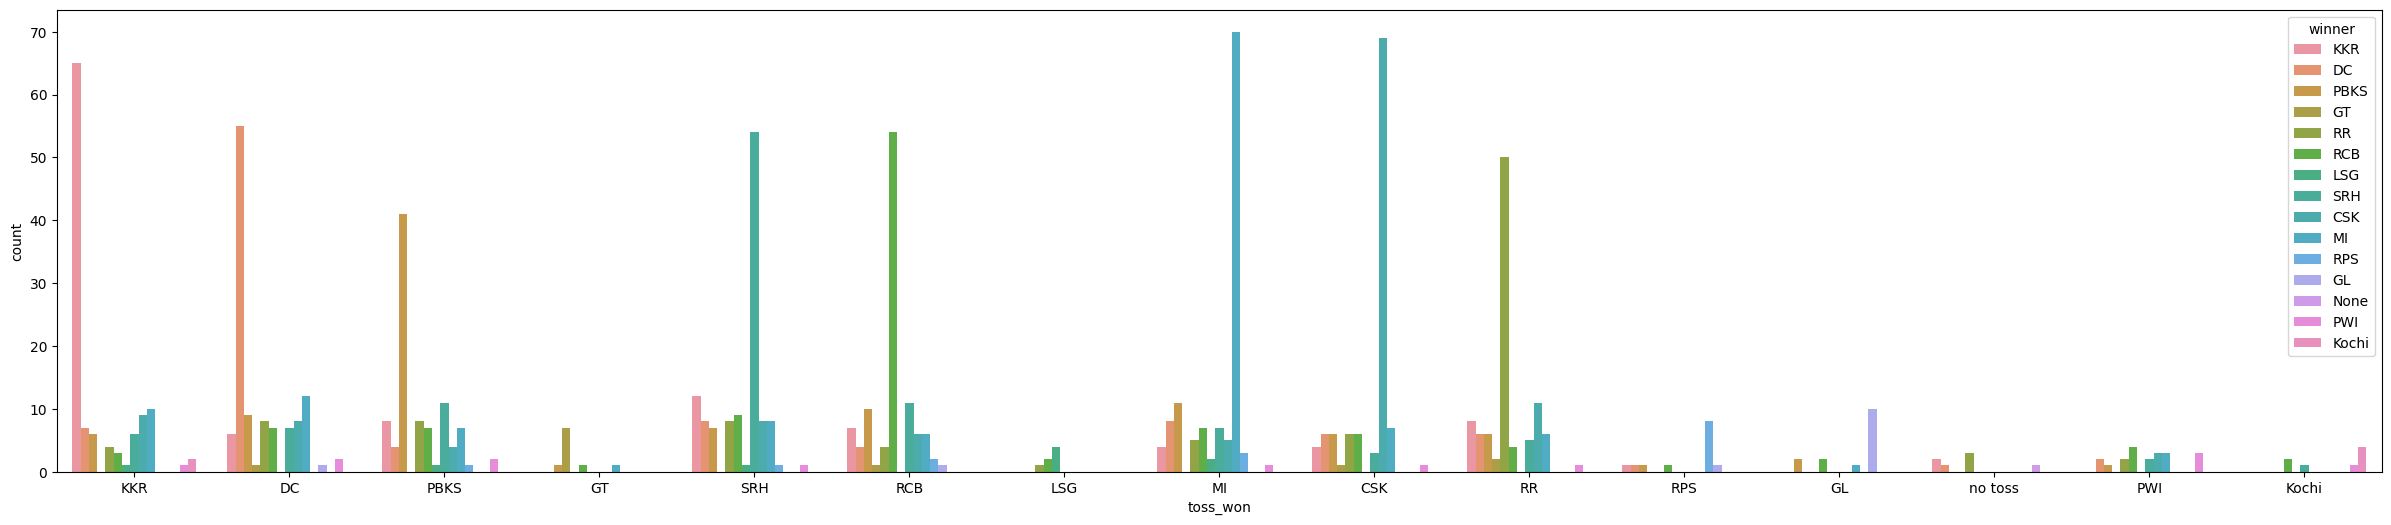

In [208]:
plt.subplots(figsize=(30,6))
sns.countplot(x='toss_won',hue='winner',data=season_summary_df)
plt.show()

**Chance of winning a match if toss won**

In [209]:
c2 = season_summary_df[(season_summary_df.winner == season_summary_df.toss_won)]
s_all = len(season_summary_df.index)
sm=len(c2.index)
print("percentage of winning match if toss is won: {}%".format((sm/s_all)*100))

percentage of winning match if toss is won: 51.56576200417536%


**Sixes and Fours Across the Season**

In [210]:
season_df=season_df.rename(columns={"match_id": "id"})
d2mat = season_summary_df[['id','season']]
d2deliv = season_df[['id','runs']]
d2 = pd.merge(d2mat,d2deliv,on='id',how='inner')

In [211]:
d24 = d2[d2.runs == 4]
d26 = d2[d2.runs == 6]

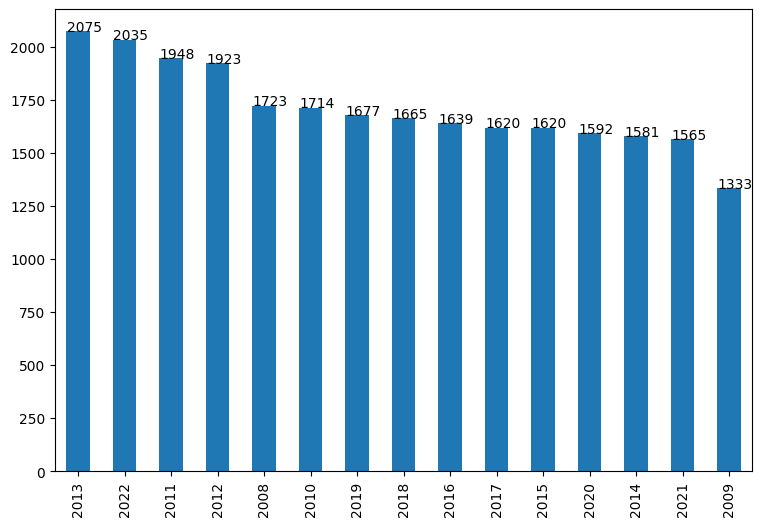

In [212]:
plt.subplots(figsize=(9,6))
d4 = d24['season'].value_counts().plot.bar(width=0.5)
for x in d4.patches:
  d4.annotate(format(x.get_height()),(x.get_x()+0.01,x.get_height()+1.05))
plt.show()

Text(0, 0.5, 'Count')

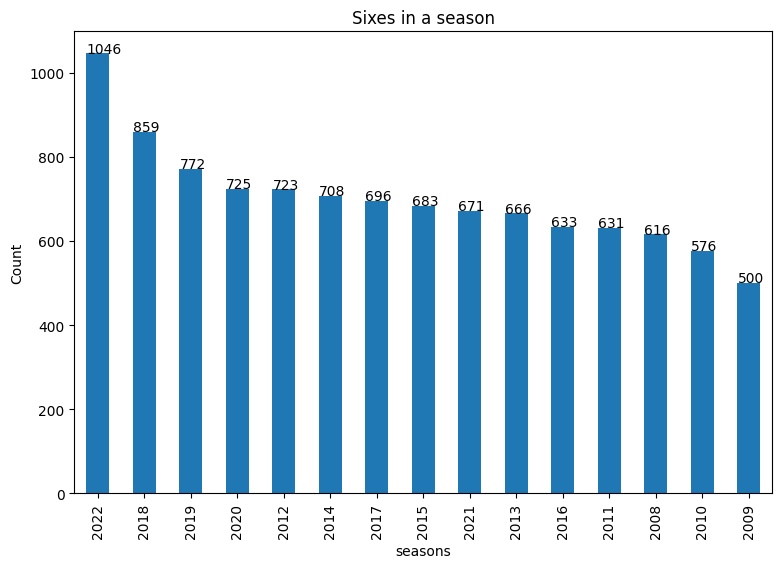

In [213]:
plt.subplots(figsize=(9,6))
d6 = d26['season'].value_counts().plot.bar(width=0.5)
for x in d6.patches:
  d6.annotate(format(x.get_height()),(x.get_x()+0.01,x.get_height()+1.5))
plt.title('Sixes in a season')
plt.xlabel('seasons')
plt.ylabel('Count')

**Runs Per Over By Teams Across Seasons**

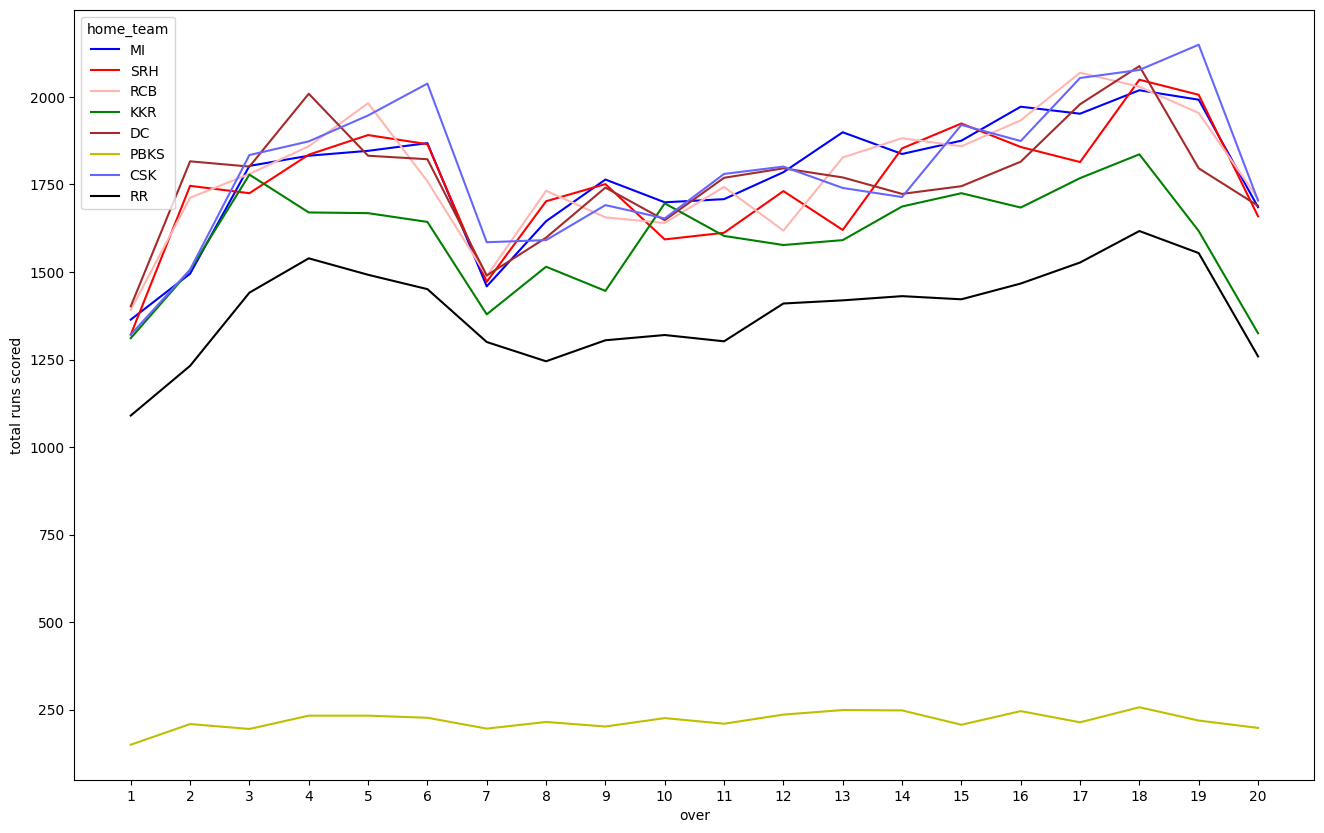

In [214]:
rpo = season_df.pivot_table(index=['over'],columns='home_team',values='runs',aggfunc=sum)
mpbt=pd.concat([season_summary_df['home_team'],season_summary_df['away_team']])
mpbt=mpbt.value_counts().reset_index()
mpbt.columns=['Team','Total Matches']
mpbt['wins']=season_summary_df['winner'].value_counts().reset_index()['winner']
mpbt.set_index('Team',inplace=True)
rpo[(mpbt[mpbt['Total Matches']>50].index)].plot(color=["b", "r", "#Ffb6b2", "g",'brown','y','#6666ff','black','#FFA500']) 
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.xticks(x)
plt.ylabel('total runs scored')
fig=plt.gcf()
fig.set_size_inches(16,10)
plt.show()

**Maximum Man of the matches**

Text(0, 0.5, 'count')

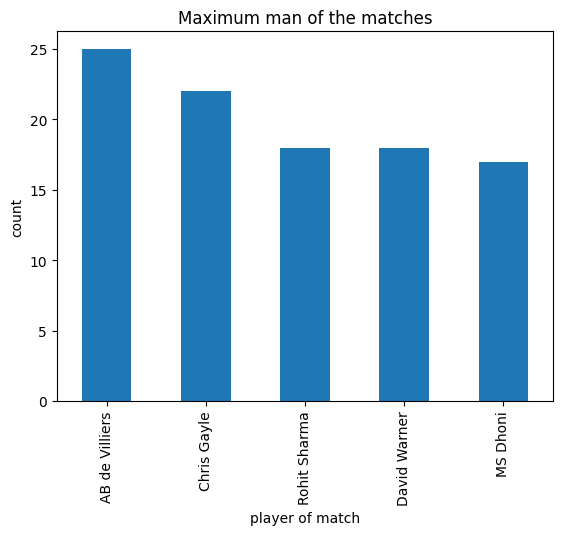

In [215]:
f2 = season_summary_df['pom'].value_counts().head().plot.bar()
#ax = matches['player_of_match'].value_counts().head(10).plot.bar(width=.8, color=sns.color_palette('inferno',10))
plt.title("Maximum man of the matches")
plt.xlabel('player of match') 
plt.ylabel('count')

**Team comparator**

In [216]:
a = 'CSK'
b = 'RCB'
mt1=season_summary_df[(((season_summary_df['home_team']==a)&(season_summary_df['away_team']==b))|((season_summary_df['home_team']==b)&(season_summary_df['away_team']==a)))]
mt1 = mt1[['home_team','away_team','winner']]
tc = mt1.groupby(['home_team','away_team','winner']).size().reset_index().rename(columns={0:'count'})
tc.loc[0,'count'] = tc.loc[0,'count'] + tc.loc[2,'count']
tc.loc[1,'count'] = tc.loc[1,'count'] + tc.loc[3,'count']
tc.loc[0,'team1_wins'] = tc.loc[0,'count']
tc.loc[0,'team2_wins'] = tc.loc[1,'count']
tc.drop(['winner','count'],axis=1,inplace=True)
tc = tc[:1]
tc

,home_team,away_team,team1_wins,team2_wins
0,CSK,RCB,20.0,10.0


**Matches Won By A Team Against Other Teams**

In [217]:
teams = season_summary_df['home_team'].unique().tolist()
our_team = 'CSK'
teams.remove(our_team)

mt1=season_summary_df[((season_summary_df['home_team']==our_team)|(season_summary_df['away_team']==our_team))]
mt1 = mt1[['home_team','away_team','winner']]
mtag = mt1.groupby(['home_team','away_team','winner']).size().reset_index().rename(columns={0:'count'})
mtag
for i in range(0,len(mtag)):
  if mtag.loc[i,'home_team'] != our_team:
    t = mtag.loc[i,'home_team']
    mtag.loc[i,'home_team'] = mtag.loc[i,'away_team']
    mtag.loc[i,'away_team'] = t
mtagg = mtag.groupby(['home_team','away_team','winner'])['count'].sum().reset_index()
for i in range(0, len(mtagg),2):
  mtagg.loc[i,'looses'] = mtagg.loc[i+1,'count']
mtagg = mtagg.iloc[::2]
mtagg = mtagg.drop('winner', axis=1)
mtagg = mtagg.drop(mtagg[mtagg['away_team'] == "GT"].index)
column_mapping = {'home_team': 'our_team', 'away_team': 'other_teams', 'count': 'wins'}
mtagg = mtagg.rename(columns=column_mapping)

mtagg

,our_team,other_teams,wins,looses
0,CSK,DC,17,10.0
4,CSK,KKR,10,1.0
6,CSK,Kochi,1,1.0
8,CSK,MI,14,20.0
10,CSK,PBKS,16,11.0
12,CSK,PWI,4,2.0
14,CSK,RCB,20,10.0
16,CSK,RR,15,11.0
18,CSK,SRH,19,9.0


**200+ scores**

In [218]:
sc = season_df.groupby(['id','home_team','innings_id'])['runs'].sum().reset_index()
plus = sc[sc['runs']>200]
plus200 = plus.sort_values(by='runs',ascending = False)
plus
plus200.head(5)

,id,home_team,innings_id,runs
701,598027,RCB,1,262
1118,980987,RCB,1,248
292,419137,CSK,1,246
1356,1136604,KXIP,1,245
2,335983,KXIP,1,240


In [219]:
season_df['bowling_team'] = np.where(season_df['current_innings']!= 'home_team', season_df['away_team'], season_df['home_team'])

In [220]:
plus2=season_df.groupby(['id', 'innings_id','current_innings','bowling_team'])['runs'].sum().reset_index()
plus2.set_index(['id'],inplace=True)
#plus2['total_runs'].max()
plus2=plus2.rename(columns={'runs':'count'})
plus2=plus2[plus2['count']>=200].groupby(['innings_id','current_innings','bowling_team']).count()
plus2

count
innings_id current_innings bowling_team       
1          CSK             CSK               6
                           DC                2
                           KKR               1
                           KXIP              1
                           MI                1
                           RCB               2
                           RR                2
           DC              DC                3
                           KKR               2
                           KXIP              1
                           MI                1
                           RR                1
                           SRH               1
           GL              GL                1
           KKR             DC                1
                           KKR               4
                           KXIP              1
                           MI                1
           KXIP            CSK               1
                           KXIP              3
                           RCB               2
                           RR                1
           LSG             LSG               1
           MI              DC                2
                           MI                7
                           RCB               1
                           RR                1
                           SRH               1
           PBKS            PBKS              2
           RCB             CSK               1
                           GL                1
                           KKR               1
                           KXIP              4
                           MI                1
                           PWI               1
                           RCB               6
                           SRH               2
           RR              CSK               1
                           DC                1
                           KKR               1
                           RR                5
                           SRH               1
           SRH             DC                1
                           KKR               1
                           KXIP              2
                           RCB               2
                           SRH               3
2          CSK             CSK               2
                           KKR               1
                           RCB               1
                           RR                1
           DC              GL                1
                           RR                1
           KKR             CSK               1
                           KKR               4
                           LSG               1
           KXIP            CSK               1
                           KKR               1
                           KXIP              4
           LSG             CSK               1
           MI              CSK               1
                           KXIP              1
                           MI                2
           PBKS            RCB               1
           RCB             KXIP              1
                           SRH               1
           RR              KXIP              1
                           PBKS              1
                           RR                3
           SRH             RR                1
                           SRH               1

**Chances of chasing 200+ target**

In [221]:
d3 = season_df.groupby(['id','innings_id','current_innings','bowling_team'])['runs'].sum().reset_index()
d33 = pd.DataFrame(columns=['id','innings_id','current_innings','bowling_team','runs'])
bb = cc = 0
for i in range(0, len(d3),2):
  a = d3.loc[i,'runs']
  b = d3.loc[i+1,'runs']
  if a>200:
    bb = bb+1
    if b>a:
      d33 = pd.concat([d33, d3[d3['id'] == d3.loc[i, 'id']]])
      cc = cc +1
print((cc/bb)*100,"%")

9.333333333333334 %


## **Bastman EDA**

**Top 10 Batsman**

<Axes: xlabel='batsman1_name'>

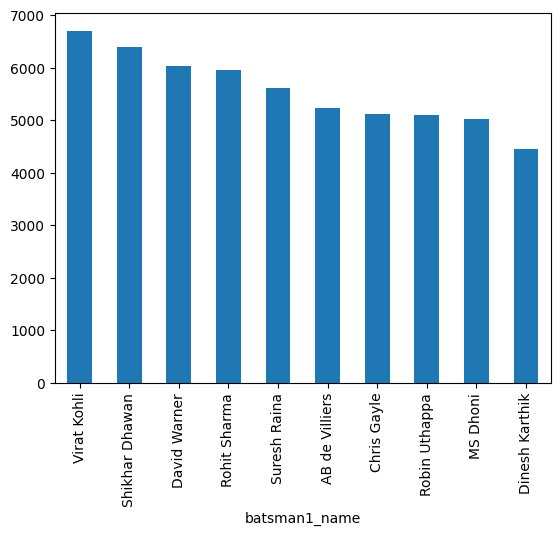

In [222]:
top = season_df.groupby(['batsman1_name'])['batsman_runs'].sum()
top10=top.sort_values(ascending=False)[:10]
top10.plot.bar()

**Top Batsman's with 1's, 2's, 3's, 4's**

In [223]:
hsr[1].sort_values(ascending=False).head().reset_index()

,batsman1_name,1
0,Virat Kohli,2219.0
1,Shikhar Dhawan,2059.0
2,Rohit Sharma,1880.0
3,Suresh Raina,1762.0
4,David Warner,1585.0


In [224]:
hsr[2].sort_values(ascending=False).head().reset_index()

,batsman1_name,2
0,Virat Kohli,378.0
1,David Warner,351.0
2,MS Dhoni,339.0
3,Shikhar Dhawan,282.0
4,Suresh Raina,273.0


In [225]:
hsr[3].sort_values(ascending=False).head().reset_index()

,batsman1_name,3
0,David Warner,24.0
1,Shikhar Dhawan,23.0
2,Virat Kohli,19.0
3,Murali Vijay,18.0
4,AB de Villiers,17.0


In [226]:
hsr[4].sort_values(ascending=False).head().reset_index()

,batsman1_name,4
0,Shikhar Dhawan,718.0
1,David Warner,594.0
2,Virat Kohli,589.0
3,Rohit Sharma,524.0
4,Suresh Raina,512.0


In [227]:
hsr[6].sort_values(ascending=False).head().reset_index()

,batsman1_name,6
0,Chris Gayle,356.0
1,AB de Villiers,250.0
2,Rohit Sharma,240.0
3,MS Dhoni,223.0
4,Virat Kohli,219.0


**Top Individual Scores**

In [228]:
tis = season_df.groupby(["id",'innings_id', "batsman1_name"])["batsman_runs"].sum().reset_index()
tis.sort_values('batsman_runs', ascending=0).head()

,id,innings_id,batsman1_name,batsman_runs
5267,598027,1,Chris Gayle,176
0,335982,1,Brendon McCullum,165
14014,1304112,1,Quinton de Kock,140
11510,1216510,1,KL Rahul,136
7485,829795,1,AB de Villiers,135


**Highest score in each inning**

In [229]:
tisi = season_df.groupby(["id",'innings_id', "batsman1_name"])["batsman_runs"].sum().reset_index()
tisi.sort_values('batsman_runs', ascending=0).head()
tisi['high_scorer']=""
tisi['high_scorer']=tisi.groupby(['id','innings_id'])['batsman_runs'].transform(max)
tisi = tisi[tisi['batsman_runs']==tisi['high_scorer']]
tisi.head()

,id,innings_id,batsman1_name,batsman_runs,high_scorer
0,335982,1,Brendon McCullum,165,165
10,335982,2,Praveen Kumar,21,21
19,335983,1,Michael Hussey,117,117
24,335983,2,James Hopes,71,71
33,335984,1,Ravindra Jadeja,32,32


**Individual Scores By Top Batsman each Inning**

In [230]:
btsmn=['Chris Gayle','Virat Kohli','Suresh Raina','AB de Villiers','David Warner']
scores = season_df.groupby(["id", "batsman1_name","current_innings"])["batsman_runs"].sum().reset_index()
scores=scores[tis['batsman1_name'].isin(btsmn)]
scores.head()

,id,batsman1_name,current_innings,batsman_runs
13,335982,Virat Kohli,RCB,5
22,335983,Matthew Hayden,CSK,26
56,335985,Virat Kohli,RCB,23
108,335989,Luke Ronchi,MI,2
163,335992,Shane Watson,RR,61


**Batsman Comparator**

In [231]:
hsr=season_df.groupby(['batsman1_name','batsman_runs'])['runs'].count().reset_index()
hsr=hsr.pivot('batsman1_name','batsman_runs','runs')

<ipython-input-231-4520e83c76a9>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  hsr=hsr.pivot('batsman1_name','batsman_runs','runs')


In [232]:
cmpBats = pd.DataFrame(columns=['batsman1_name','dots','singles','Twos','Threes','Fours','Sixes','total_runs','Average','Strike_rate'])

dfc=season_df.groupby(['batsman1_name'])['ball'].count().reset_index()
runs=season_df.groupby(['batsman1_name'])['batsman_runs'].sum().reset_index()

dots=season_df.groupby('batsman1_name')['batsman_runs'].agg(lambda x: (x==0).sum()).reset_index()
ones=season_df.groupby('batsman1_name')['batsman_runs'].agg(lambda x: (x==1).sum()).reset_index()
twos=season_df.groupby('batsman1_name')['batsman_runs'].agg(lambda x: (x==2).sum()).reset_index()
threes=season_df.groupby('batsman1_name')['batsman_runs'].agg(lambda x: (x==3).sum()).reset_index()
fours=season_df.groupby(['batsman1_name'])['batsman_runs'].agg(lambda x: (x==6).sum()).reset_index()
sixes=season_df.groupby('batsman1_name')['batsman_runs'].agg(lambda x: (x==4).sum()).reset_index()

dfc=dfc.merge(dots,on='batsman1_name',how='outer')
dfc.rename(columns={'batsman_runs':'dots'},inplace=True)
dfc=dfc.merge(ones,on='batsman1_name',how='outer')
dfc.rename(columns={'batsman_runs':'ones'},inplace=True)
dfc=dfc.merge(twos,on='batsman1_name',how='outer')
dfc.rename(columns={'batsman_runs':'twos'},inplace=True)
dfc=dfc.merge(threes,on='batsman1_name',how='outer')
dfc.rename(columns={'batsman_runs':'threes'},inplace=True)
dfc=dfc.merge(sixes,on='batsman1_name',how='outer')
dfc.rename(columns={'batsman_runs':'Fours'},inplace=True)
dfc=dfc.merge(fours,on='batsman1_name',how='outer')
dfc.rename(columns={'batsman_runs':'sixes'},inplace=True)
dfc=dfc.merge(runs,on='batsman1_name',how='outer')

runs=season_df.groupby(['batsman1_name'])['batsman_runs'].sum().reset_index()
dfc.rename({'ball':'balls_faced','batsman_runs':'runs_scored'},axis=1,inplace=True)
dfc['strike_rate']=dfc['runs_scored']/dfc['balls_faced']*100
dfc.head(10)

,batsman1_name,balls_faced,dots,ones,twos,threes,Fours,sixes,runs_scored,strike_rate
0,AB de Villiers,3468,1044,1474,266,17,417,250,5225,150.663206
1,Aakash Chopra,75,44,22,2,0,7,0,54,72.000000
2,Aaron Finch,1692,688,594,109,4,219,78,2168,128.132388
3,Abdul Samad,160,55,66,13,0,12,14,224,140.000000
4,Abdur Razzak,2,2,0,0,0,0,0,0,0.000000
5,Abhijeet Tomar,8,7,0,0,0,1,0,4,50.000000
6,Abhimanyu Mithun,26,9,9,3,0,4,1,37,142.307692
7,Abhinav Manohar,79,30,30,2,0,14,3,108,136.708861
8,Abhinav Mukund,22,8,11,2,0,1,0,19,86.363636
9,Abhishek Jhunjhunwala,218,94,84,13,2,20,5,226,103.669725


**Compare Rohit Sharma and Virat Kohli on runs scored and strike rate**


In [233]:
cmp = pd.DataFrame()
cmp = cmp.append(dfc[dfc['batsman1_name']=='Virat Kohli'])
cmp = cmp.append(dfc[dfc['batsman1_name']=='Rohit Sharma'])
cmp

<ipython-input-233-6816f1331c06>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmp = cmp.append(dfc[dfc['batsman1_name']=='Virat Kohli'])
<ipython-input-233-6816f1331c06>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmp = cmp.append(dfc[dfc['batsman1_name']=='Rohit Sharma'])


,batsman1_name,balls_faced,dots,ones,twos,threes,Fours,sixes,runs_scored,strike_rate
583,Virat Kohli,5253,1829,2219,378,19,589,219,6702,127.584238
443,Rohit Sharma,4622,1718,1880,252,7,524,240,5946,128.645608


# **Bowlers EDA**

**Highest Wicket Taker**

<Axes: xlabel='fullName'>

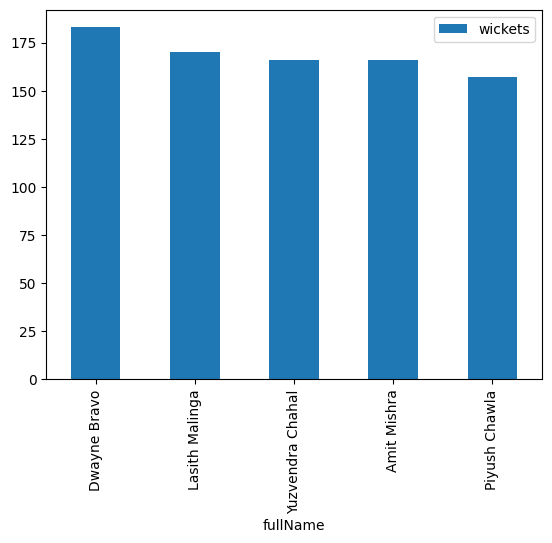

In [234]:
hwt=bowling_df.groupby(["fullName"])["wickets"].sum().reset_index()
hwt1=hwt.sort_values(by="wickets", ascending=False).head(5).reset_index()

hwt1
hwt1.plot.bar(x='fullName', y='wickets')

**Maximum Overs**

<Axes: xlabel='fullName'>

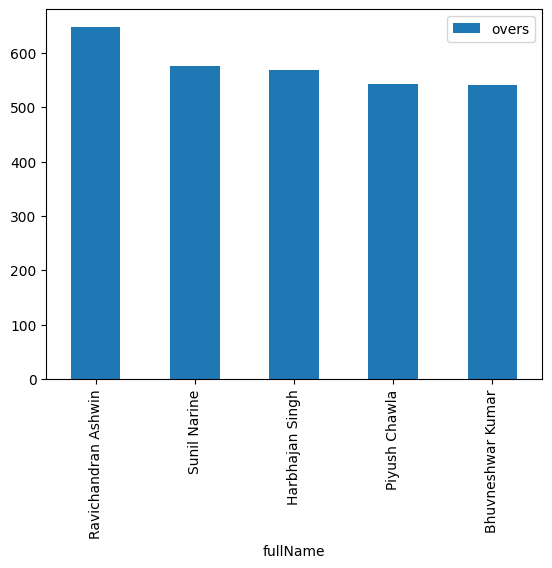

In [235]:
mo = bowling_df.groupby(["fullName"])["overs"].sum().reset_index()
mo1=mo.sort_values(by="overs", ascending=False).head(5).reset_index()

# mo1
mo1.plot.bar(x='fullName', y='overs')

**Most Economical Bowlers with 300+ overs**


<Axes: xlabel='fullName'>

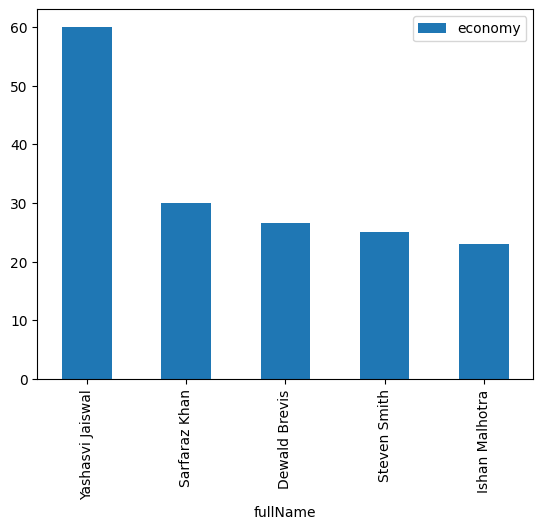

In [236]:
meb = pd.DataFrame(bowling_df, columns=['fullName','overs','conceded','wickets'])
meb = meb.groupby(['fullName']).sum().reset_index() 
meb["economy"] = (meb['conceded']/meb['overs'])
meb=meb.sort_values(by="economy", ascending=False).head(5).reset_index()
meb.plot.bar(x='fullName', y='economy')

## **Predictions**

In [237]:
encoder = LabelEncoder()

cols = ['home_team', 'away_team', 'toss_won', 'decision', 'winner']
season_summary_df = season_summary_df.loc[:, cols].copy()  # Use .loc to create a copy of the selected columns
for col in cols:
  season_summary_df[col] = encoder.fit_transform(season_summary_df[col])
season_summary_df.head()

,home_team,away_team,toss_won,decision,winner
0,0,4,4,1,4
1,1,7,1,1,1
2,8,10,8,1,9
3,3,6,3,1,3
4,13,12,13,1,13


In [238]:
x=season_summary_df.drop(['winner'],axis=1)
y=season_summary_df['winner']

In [239]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=20) 
max_acc_score = 0.0
test_size_list = [0.1, 0.2, 0.3]
for test in test_size_list:
  for randm in range(10, 49):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test,random_state=randm) 
    for estim in range(12, 20):
      for depth in range(7, 17):
        random_forest=RandomForestClassifier(n_estimators=estim,max_depth=depth)
        random_forest.fit(x_train,y_train)
        y_pred=random_forest.predict(x_test)
        acc_score=metrics.accuracy_score(y_test,y_pred) #gives the accuracy of the model
        if acc_score > max_acc_score:
          max_acc_score = acc_score
          max_test, max_random, max_estim, max_depth = test, randm, estim, depth

print("Accuracy of Test:", max_acc_score)
print("test_size = {}, \nrandom_state= {} \nestimatros= {}\ndepth= {}".format(max_test, max_random, max_estim, max_depth))

Accuracy of Test: 0.6666666666666666
test_size = 0.1, 
random_state= 11 
estimatros= 16
depth= 8


**Random Forest**

In [165]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=20) 

random_forest=RandomForestClassifier(n_estimators=19,max_depth=16)
random_forest.fit(x_train,y_train) 

RandomForestClassifier(max_depth=16, n_estimators=19)

In [166]:
y_pred=random_forest.predict(x_test)
y_pred_train=random_forest.predict(x_train)

acc_score=metrics.accuracy_score(y_test,y_pred) #gives the accuracy of the model
print("Accuracy of Test:", acc_score)

Accuracy of Test: 0.7291666666666666


**KNN Classifier**

In [180]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=20) 
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=2)

In [181]:
y_pred=knn.predict(x_test)
acc_score=metrics.accuracy_score(y_test,y_pred) #gives the accuracy of the model
print("Accuracy of Test:", acc_score)

Accuracy of Test: 0.625


**Decision Tree**

In [182]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=34)

dtree=DecisionTreeClassifier(criterion='entropy',max_depth=9)
dtree.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9)

In [183]:
y_pred=dtree.predict(x_test)
acc_score=metrics.accuracy_score(y_test,y_pred) #gives the accuracy of the model
print("Accuracy of Test:", acc_score)

Accuracy of Test: 0.625


**Logistic Regression**

In [190]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=34)

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [192]:
y_pred=logreg.predict(x_test)
acc_score=metrics.accuracy_score(y_test,y_pred) #gives the accuracy of the model
print("Accuracy of Test:", acc_score)

Accuracy of Test: 0.13541666666666666


**SVM**

In [194]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=17)

svm=SVC(kernel='poly')  
svm.fit(x_train,y_train)

SVC(kernel='poly')

In [196]:
y_pred=svm.predict(x_test)
y_pred_train=svm.predict(x_train) #y_pred is prediction of test data

acc_score=metrics.accuracy_score(y_test,y_pred) #gives the accuracy of the model
print("Accuracy of Test:", acc_score)

Accuracy of Test: 0.5
